# AI Ethics Project - STARTER

Personalization is a central aspect of many core AI systems. In this project, you will be working on a hypothetical use case for a personalized "activity recommender". The use case has a medium ethical AI risk level and involves a synthetic dataset.

IDOOU is a mobile app users can leverage to get recommendations on activities they can take in a given area, like “visiting a movie theater”, “visiting a park”, “sightseeing”, “hiking”, or “visiting a library”.


**Problem statement**:

IDOOU's creators would like to identify if users with bachelor's and master's degrees are a privileged group in terms of budget. In other words, do users with higher education credentials beyond high school have a budget >= $300 compared to users of the app who graduated from high school? 

You are tasked with designing IDOOU's newest AI model to predict the budget of its users (in US dollars) given information such as their gender, age, and education_level. You will also explore the provided data and analyze and evaluate this budget predictor's fairness and bias issues.


**Key points**:

- The training data was conducted through a user experience study of about 300,000 participants.
- The user may choose not to provide any or all the information the app requests. The training data also reflects this.
- Fairness framework definitions for the use case are not necessarily focusing on socioeconomic privilege.

In [1]:
# !pip install aif360
# !pip install tensorflow
# !pip install jinja2
# !pip install fairlearn

**Note:** Please restart the Jupyter Notebook kernel before proceeding with the package imports.

In [2]:
#You may add additional imports as needed
import pandas as pd
import numpy as np
import seaborn as sns
import tempfile
from aif360.datasets import StandardDataset, BinaryLabelDataset
from aif360.metrics import ClassificationMetric, BinaryLabelDatasetMetric
from sklearn.tree import DecisionTreeClassifier
from aif360.algorithms.postprocessing import RejectOptionClassification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
import joblib
import matplotlib.pyplot as plt
from collections import defaultdict

In [3]:
#Load the dataset for this project
act_rec_dataset = pd.read_csv('udacity_ai_ethics_project_data.csv')
act_rec_dataset.head()

,Budget (in dollars),Age,Gender,Education_Level,With children?,Recommended_Activity
0,3258.0,29.0,Transgender,Bachelor’s Degree,0.0,Stay in: Watch calming TV
1,1741.0,89.0,Other,Bachelor’s Degree,NaN,Play: Visit a movie theater
2,140.0,22.0,NaN,Other,0.0,Play: Visit a movie theater
3,179.0,23.0,Non-binary,Other,0.0,Play: Visit a movie theater
4,3479.0,79.0,Non-binary,Master’s Degree,1.0,Learn: Visit a library


## Step 1: Data Pre-Processing and Evaluation

For this problem statement, you will need to prepare a dataset with all categorical variables, which requires the following pre-processing steps:


- Remove the NA values from the dataset
- Convert Age and Budget (in dollars) to categorical columns with the following binning:

> Bins for Age: 18-24, 25-44, 45-65, 66-92

> Bins for Budget: >=300, <300

In [4]:
act_rec_dataset.shape

(300000, 6)

In [5]:
act_rec_dataset.dropna(inplace=True)
act_rec_dataset.isna().sum()

Budget (in dollars)     0
Age                     0
Gender                  0
Education_Level         0
With children?          0
Recommended_Activity    0
dtype: int64

In [6]:
act_rec_dataset.shape

(156317, 6)

In [7]:
bins_age=[0,18, 24, 44, 65,92]
act_rec_dataset['Age']=pd.cut(act_rec_dataset['Age'], bins_age)

In [8]:
act_rec_dataset.isna().sum()

Budget (in dollars)     0
Age                     0
Gender                  0
Education_Level         0
With children?          0
Recommended_Activity    0
dtype: int64

In [9]:
act_rec_dataset['Age'].value_counts()

(18, 24]    64069
(24, 44]    52417
(44, 65]    18315
(0, 18]     12577
(65, 92]     8939
Name: Age, dtype: int64

In [10]:
act_rec_dataset.shape

(156317, 6)

In [11]:
act_rec_dataset.Age.unique()

[(24, 44], (18, 24], (65, 92], (0, 18], (44, 65]]
Categories (5, interval[int64, right]): [(0, 18] < (18, 24] < (24, 44] < (44, 65] < (65, 92]]

In [12]:
act_rec_dataset['Budget (in dollars)']=np.where(act_rec_dataset['Budget (in dollars)']<300,\
                                               "<300",">=300")

In [13]:
#FILL IN - the below dataframe should be pre-processed
act_rec_dataset.head()

,Budget (in dollars),Age,Gender,Education_Level,With children?,Recommended_Activity
0,>=300,"(24, 44]",Transgender,Bachelor’s Degree,0.0,Stay in: Watch calming TV
3,<300,"(18, 24]",Non-binary,Other,0.0,Play: Visit a movie theater
4,>=300,"(65, 92]",Non-binary,Master’s Degree,1.0,Learn: Visit a library
5,>=300,"(24, 44]",Male,Bachelor’s Degree,1.0,Play: Go shopping
6,>=300,"(24, 44]",Non-binary,Master’s Degree,0.0,Explore: Go sightseeing


### Evaluate bias issues in the dataset

Next, let's take a look at potential hints of data bias in the variables, particularly the "Gender", "Age", and "Education" variables.

Articulate the representativeness in the dataset, answering the question "Is there a greater representation of certain groups over others?"

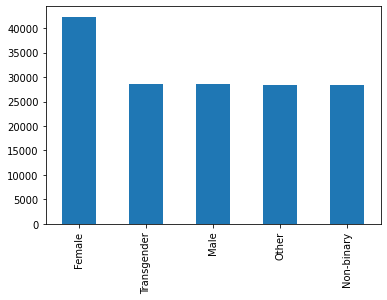

In [14]:
#FILL IN
#Generate visualizations to understand the representativeness of the dataset
act_rec_dataset['Gender'].value_counts().plot(kind='bar');

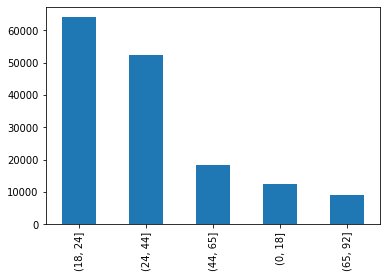

In [15]:
act_rec_dataset['Age'].value_counts().plot(kind='bar');

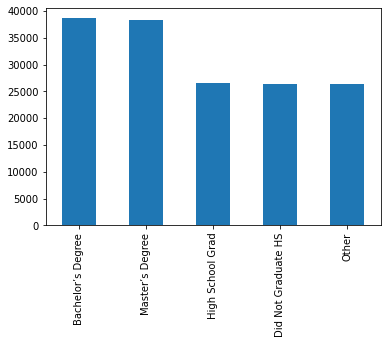

In [16]:
act_rec_dataset['Education_Level'].value_counts().plot(kind='bar');

Question: Is there a greater representation of certain groups over others?

**Your answer:**
Female is prominent among genders. However, for age and education level, we can perform chi squared test for checking uniformity with 3 and 4 degrees of freedom. On precursory look, it looks there is distribution difference among classes and may not be uniform. There are more young population with bachelors and masters degree.

Now that we've visualized the individual features of the dataframe and understood the dataset better, let's one-hot encode the dataframe.

In [17]:
#FILL IN: 
categorical_columns=[x for x in act_rec_dataset.columns if x!='With children?']
#The variable act_rec_dataset should contain the one-hot encoded variables
act_rec_dataset= pd.get_dummies(
        act_rec_dataset, columns=categorical_columns
    )

Visualize the interactions between the categorical variables. Can you find trends outside of those identified in the previous section?

**Hint**: Use a multicollinearity matrix.

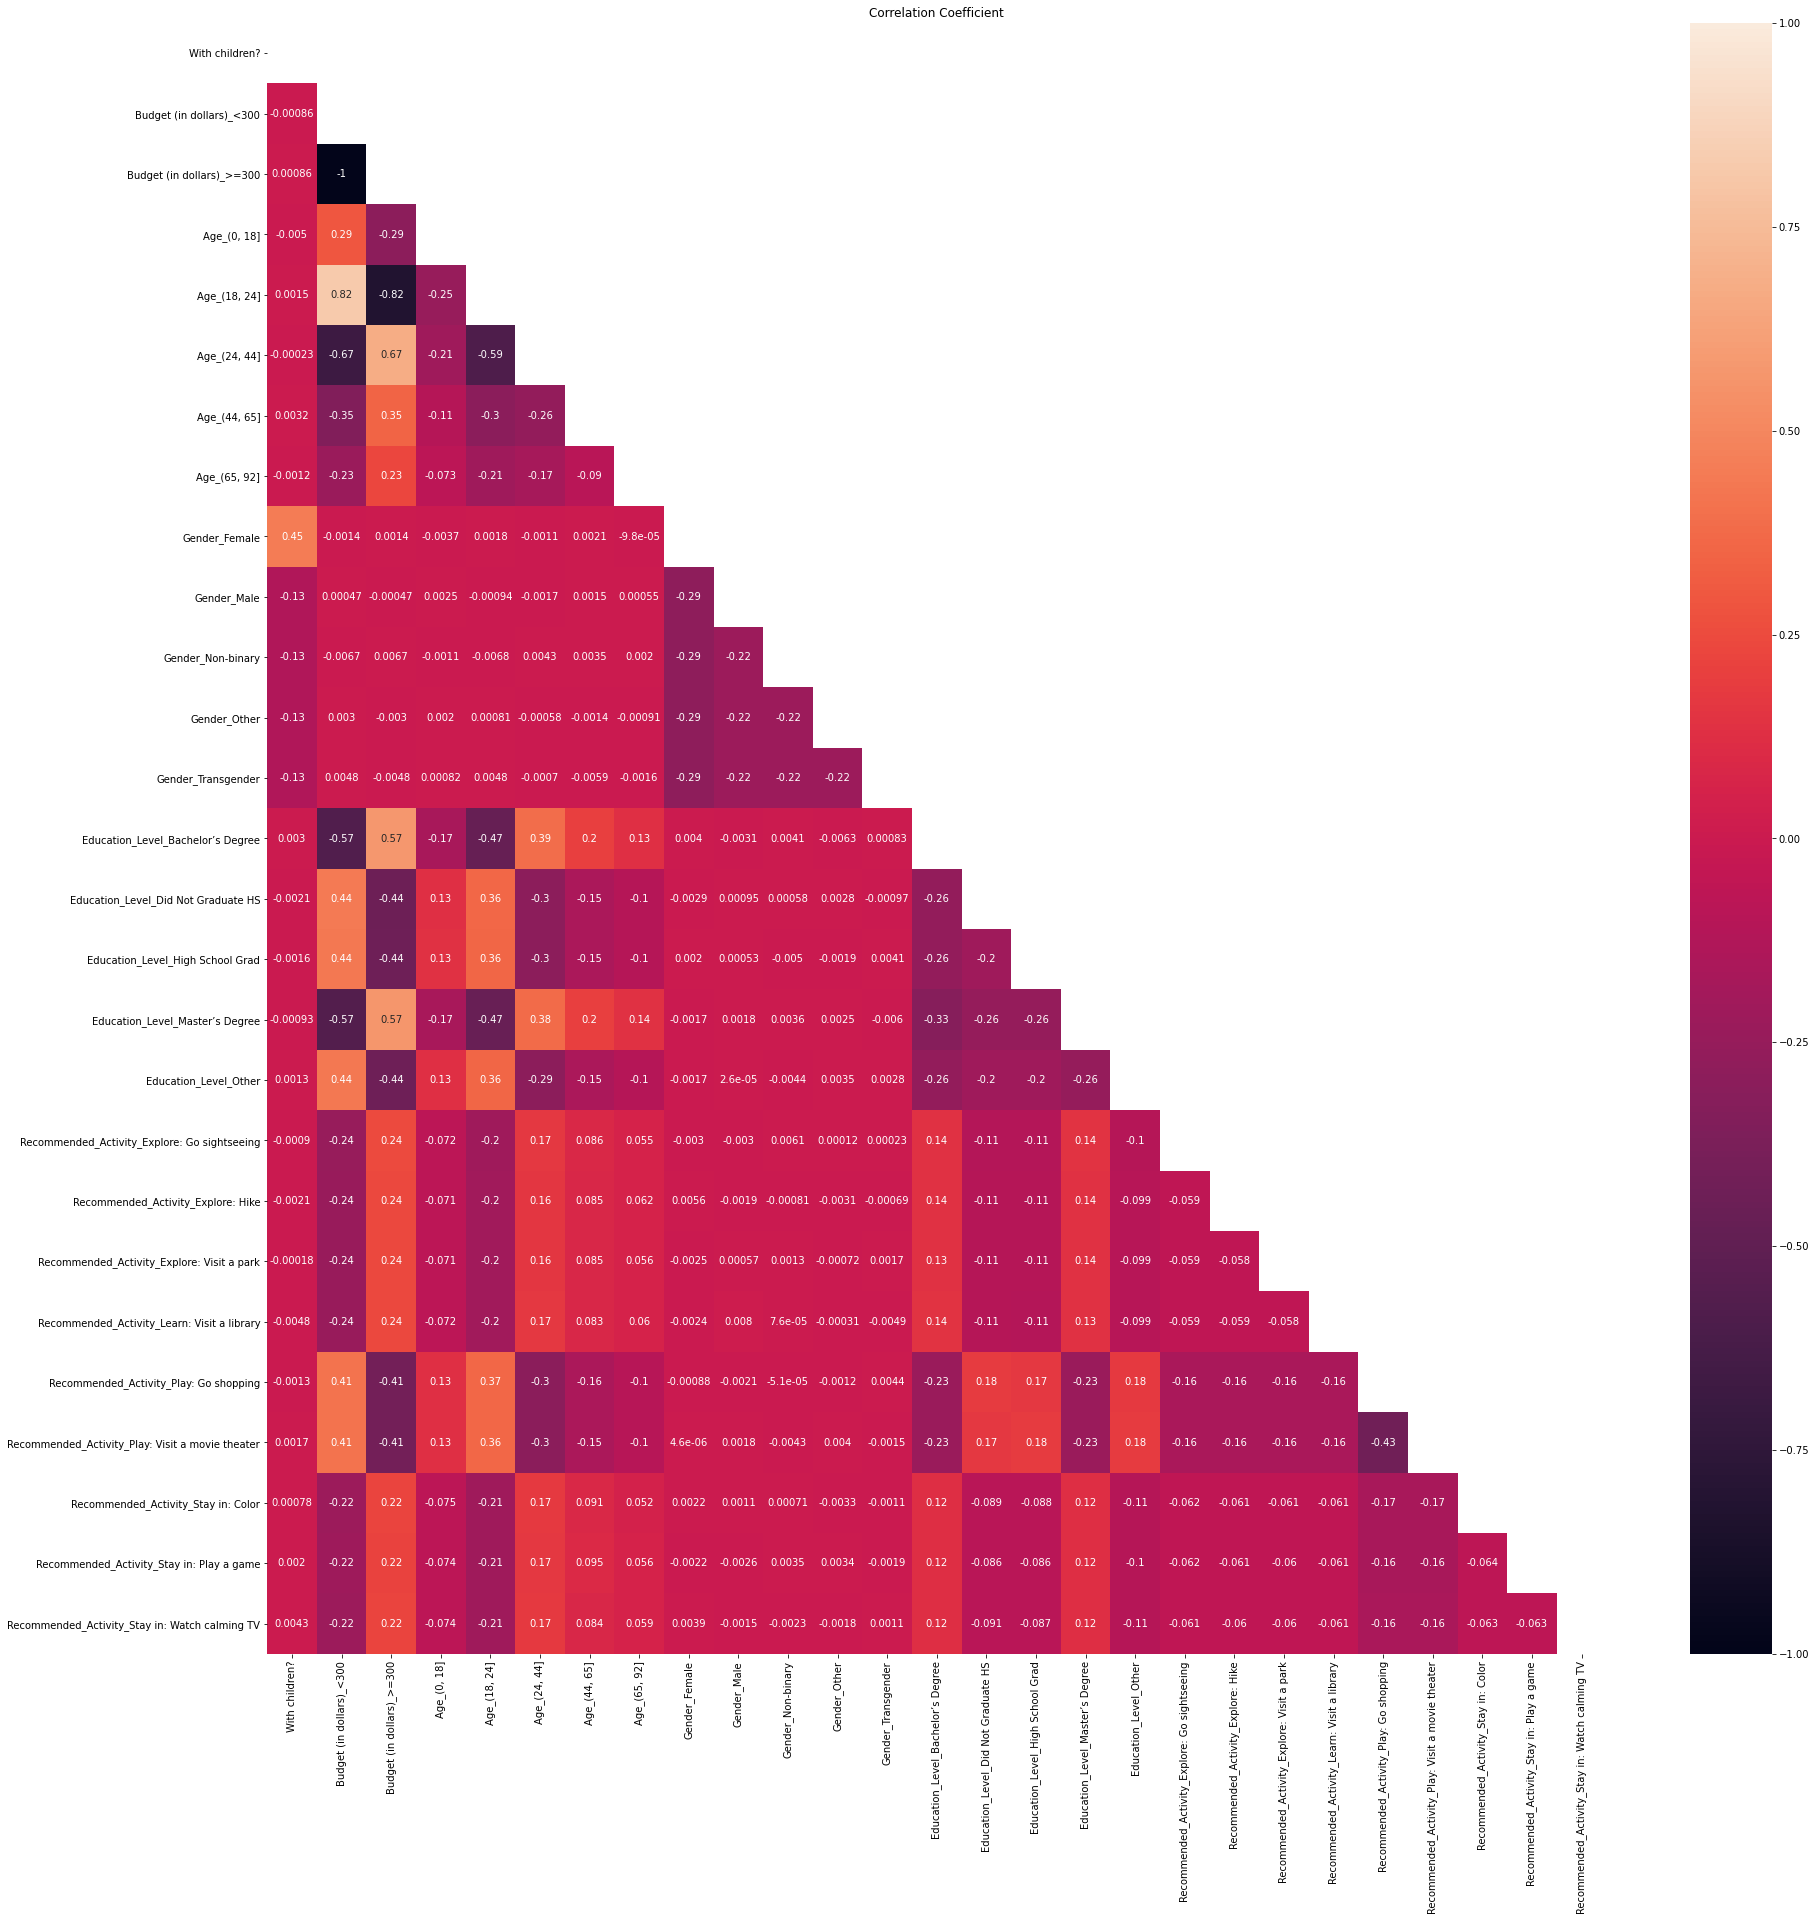

In [18]:
#FILL IN
import seaborn as sns

# set figure size
plt.figure(figsize=(30,30))

# Generate a mask to onlyshow the bottom triangle
mask = np.triu(np.ones_like(act_rec_dataset.corr(), dtype=bool))

# generate heatmap
sns.heatmap(act_rec_dataset.corr(), annot=True, mask=mask, vmin=-1, vmax=1)
plt.title('Correlation Coefficient')
plt.show()


Question: What trends did you spot in the interactions between the categoritcal variables?

**Your answer:**
Under 18 have low budget.From 24 to 44, budget capacity increases and slowly declines with age. Less male are associated with child. Bachelors and master have more budget.
People with low budget with age 18-24 tend to go to shopping or movie theatre.

For the purposes of this project, we will drop the following elements from the dataframe:

- Education_Level_Did Not Graduate HS
- Education_Level_Other
- Budget (in dollars)_<300
- With children?

In [19]:
#We drop certain variables that are highly correlated and irrelevant
act_rec_dataset = act_rec_dataset.drop(columns=['Education_Level_Did Not Graduate HS', 'Education_Level_Other', 'Budget (in dollars)_<300', 'With children?'])
act_rec_dataset.head()

,Budget (in dollars)_>=300,"Age_(0, 18]","Age_(18, 24]","Age_(24, 44]","Age_(44, 65]","Age_(65, 92]",Gender_Female,Gender_Male,Gender_Non-binary,Gender_Other,...,Education_Level_Master’s Degree,Recommended_Activity_Explore: Go sightseeing,Recommended_Activity_Explore: Hike,Recommended_Activity_Explore: Visit a park,Recommended_Activity_Learn: Visit a library,Recommended_Activity_Play: Go shopping,Recommended_Activity_Play: Visit a movie theater,Recommended_Activity_Stay in: Color,Recommended_Activity_Stay in: Play a game,Recommended_Activity_Stay in: Watch calming TV
0,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,1,0,0,0,0,1,0,0,1,0,...,1,0,0,0,1,0,0,0,0,0
5,1,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
6,1,0,0,1,0,0,0,0,1,0,...,1,1,0,0,0,0,0,0,0,0


### Evaluate fairness issues

Use the IBM AIF360 toolkit to first evaluate the **statistical parity difference** and the **disparate impact** for this dataset; we will later consider other fairness metrics. Interpret your findings - is there bias in the proposed problem statement? If yes, what group is benefitting?

**Hint**: Use the BinaryLabelDataset and the BinaryLabelDatasetMetric functions for the fairness evaluation. The reported Statistical Parity Difference may be within -0.64 and -0.55, and the Disparate impact value may be within 0.136 and 0.0150.

In [20]:
[x for x in act_rec_dataset if 'Education' in x]

['Education_Level_Bachelor’s Degree',
 'Education_Level_High School Grad',
 'Education_Level_Master’s Degree']

In [21]:
binary_act_dataset = BinaryLabelDataset(df=act_rec_dataset,\
                                        favorable_label=0,
                                        unfavorable_label=1,
                                       label_names=['Budget (in dollars)_>=300'],\
                                       protected_attribute_names=['Education_Level_High School Grad'])

privileged_groups = [{'Education_Level_High School Grad':0}]
unprivileged_groups = [{'Education_Level_High School Grad':1}]

In [22]:
orig_metric_act_dataset = BinaryLabelDatasetMetric(binary_act_dataset,privileged_groups,unprivileged_groups)

print("Statistical Parity Difference =",orig_metric_act_dataset.mean_difference())
print(f"Disparate impact =",orig_metric_act_dataset.disparate_impact())

Statistical Parity Difference = -0.5830640114557069
Disparate impact = 0.41175961534295263


Question: Evaluate the fairness metrics. What are your findings? Is there bias in the proposed problem statement? If yes, what group is benefitting?

**Your answer:**
From statistical parity, it looks there is disadvantage in selection for high school.
Similarly, the ratio of selection rate via disparate impact shows there is biasness. 
In both cases,higher education is associated with high budget.

## Step 2: Investigate an ML model on the problematic Dataset

For this project, we are using a train-test-validation split.

You have available boilerplate for training 2 ML models on this dataset - you will need to train these models and use the methods we covered in this course to identify and evaluate their performance (**using the accuracy metric and confusion matrix**).

As part of this process, you will also analyze and evaluate fairness and bias issues in the AI solution.

In [23]:
(orig_train,
 orig_validate,
 orig_test) = binary_act_dataset.split([0.5, 0.8], shuffle=True)

In [24]:
#Source: Helper code snippet from https://github.com/Trusted-AI/AIF360/blob/master/examples/tutorial_medical_expenditure.ipynb
def test(dataset, model, thresh_arr):
    y_val_pred_prob = model.predict_proba(dataset.features)
    y_val_pred = model.predict(dataset.features)
    pos_ind = np.where(model.classes_ == dataset.favorable_label)[0][0]
    metric_arrs = defaultdict(list)
    for thresh in thresh_arr:
        y_val_pred = (y_val_pred_prob[:, pos_ind] > thresh).astype(np.float64)

        dataset_pred = dataset.copy()
        dataset_pred.labels = y_val_pred
        metric = ClassificationMetric(
                dataset, dataset_pred,
                unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)

        metric_arrs['bal_acc'].append((metric.true_positive_rate()
                                     + metric.true_negative_rate()) / 2)
        metric_arrs['avg_odds_diff'].append(metric.average_odds_difference())
        metric_arrs['disp_imp'].append(metric.disparate_impact())
        metric_arrs['stat_par_diff'].append(metric.statistical_parity_difference())
        metric_arrs['eq_opp_diff'].append(metric.equal_opportunity_difference())
        metric_arrs['theil_ind'].append(metric.theil_index())
    
    return metric_arrs, y_val_pred

def describe_metrics(metrics, thresh_arr):
    best_ind = np.argmax(metrics['bal_acc'])
    print("Threshold corresponding to Best balanced accuracy: {:6.4f}".format(thresh_arr[best_ind]))
    print("Best balanced accuracy: {:6.4f}".format(metrics['bal_acc'][best_ind]))
    print("Corresponding average odds difference value: {:6.4f}".format(metrics['avg_odds_diff'][best_ind]))
    print("Corresponding statistical parity difference value: {:6.4f}".format(metrics['stat_par_diff'][best_ind]))
    print("Corresponding equal opportunity difference value: {:6.4f}".format(metrics['eq_opp_diff'][best_ind]))
    print("Corresponding Theil index value: {:6.4f}".format(metrics['theil_ind'][best_ind]))

In [25]:
orig_train.labels.ravel()

array([0., 0., 0., ..., 1., 0., 0.])

In [26]:
GNB_model = GaussianNB().fit(orig_train.features, orig_train.labels.ravel(), orig_train.instance_weights) 
thresh_arr = np.linspace(0.01, 0.5, 50)
val_metrics, gnb_pred = test(dataset=orig_validate,
                   model=GNB_model,
                   thresh_arr=thresh_arr)
describe_metrics(val_metrics, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.0100
Best balanced accuracy: 0.0128
Corresponding average odds difference value: -0.4794
Corresponding statistical parity difference value: -0.5978
Corresponding equal opportunity difference value: -0.0283
Corresponding Theil index value: 0.6906


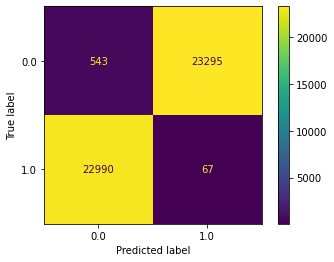

In [27]:
#FILL IN
#Evaluate the accuracy of the model
accuracy_score(y_true=orig_validate.labels.ravel(), y_pred=gnb_pred)
#Visualize the performance (confusion matrix) of the model
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(orig_validate.labels.ravel(), y_pred=gnb_pred)

In [28]:
LR_model = LogisticRegression().fit(orig_train.features, orig_train.labels.ravel(), orig_train.instance_weights)

In [29]:
#Load the Logistic Regression model
thresh_arr = np.linspace(0.01, 0.5, 50)
val_metrics, lr_pred = test(dataset=orig_validate,
                   model=LR_model,
                   thresh_arr=thresh_arr)
describe_metrics(val_metrics, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.0100
Best balanced accuracy: 0.0048
Corresponding average odds difference value: -0.4974
Corresponding statistical parity difference value: -0.5857
Corresponding equal opportunity difference value: -0.0007
Corresponding Theil index value: 0.7109


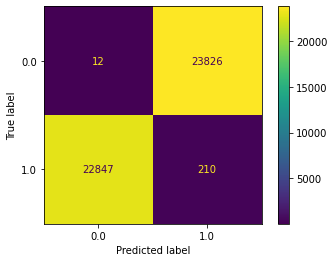

In [30]:
#FILL IN
#Evaluate the accuracy of the model
accuracy_score(y_true=orig_validate.labels.ravel(), y_pred=lr_pred)
#Visualize the performance (confusion matrix) of the model
ConfusionMatrixDisplay.from_predictions(orig_validate.labels.ravel(), y_pred=lr_pred)

In [31]:
# BinaryLabelDatasetMetric(GNB_model.pred(orig_test), privileged_groups, unprivileged_groups)

In [32]:
#Fill IN
#Compare the model accuracy on test dataset either in a bar plot or table format
accuracy_compare=[{'GNB':accuracy_score(y_true=orig_validate.labels.ravel(), y_pred=gnb_pred),
                  'LR':accuracy_score(y_true=orig_validate.labels.ravel(), y_pred=lr_pred)}]
pd.DataFrame(accuracy_compare)

,GNB,LR
0,0.013008,0.004734


In [33]:
#FILL IN Optional
#Compare the fairness metrics on test dataset
test_metrics, gnb_pred = test(dataset=orig_test,
                   model=GNB_model,
                   thresh_arr=thresh_arr)
describe_metrics(test_metrics, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.0100
Best balanced accuracy: 0.0131
Corresponding average odds difference value: -0.4726
Corresponding statistical parity difference value: -0.5986
Corresponding equal opportunity difference value: -0.0302
Corresponding Theil index value: 0.6951


In [34]:
test_metrics, lr_pred = test(dataset=orig_test,
                   model=LR_model,
                   thresh_arr=thresh_arr)
describe_metrics(test_metrics, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.0100
Best balanced accuracy: 0.0048
Corresponding average odds difference value: -0.4968
Corresponding statistical parity difference value: -0.5850
Corresponding equal opportunity difference value: -0.0001
Corresponding Theil index value: 0.7165


Question: Interpret and compare the results of each model. What do you find in the false negative and false positive of each model? What about the fairness metrics?

**Your answer:**
Both the models are bad. However, GNB is performing better in terms of confusion matrix. When comparing the fairness metrics, theil index shows thats LR is farther away, which can be tallied with average odds difference as well.

Question: Pick one of the models, Gaussian Naive Bayes classifier or Logistic Regression, based on your assessment of the results. Briefly explain your reason.

**Your answer:**
GNB is better model of the two because of better confusion matrix and better fairness index

## Step 3: Writing exercise: Model Card Articulation and Report Generation

Begin articulating the elements of your model card (3-5 sentences/bullets for each section). Please delineate bullet points using two hyphens, as show in the example below.

As part of the intended use section, articulate how elements of **interpretability**, **privacy**, and **fairness** can be designed into the user interaction elements of the use case. **Hint:** Should IDOOU prompt the user to check whether the budget predictor model's results are correct?

In [35]:
model_details = """
-- Budget Predicter AI is a model that provides
-- personalized activity recommendation
-- that they can take in an area
"""
intended_use = """
-- based on weather, area
-- and users' interest, the application
-- is able to provide the right kind of recommendation
"""
factors = """
-- education
-- budget
-- age
-- gender
"""

Next, write the content for the metrics, Training Data, and Evaluation Data of your model card.

In [36]:
metrics = """
-- balanced accuracy
-- statistical parity difference
-- Theil Index
-- Average odds difference
"""
training_data = """
-- 50% randomized data after removing missing values
"""
eval_data = """
-- 30% validation data for tuning and evaluating performance
"""

## Step 4: Use Interpretability mechanisms

Use an interpretability mechanism(s) of your choice, e.g. permutation importance, LIME, etc., to understand the feature importance and model's predictions on the test dataset. **Visualize** and note down the key contributing factors - you will later incorporate this in your model card.

In [37]:
#FILL IN
#Use an interpretability mechanism to investigate the AI model you chose
from sklearn.inspection import permutation_importance
result = permutation_importance(GNB_model, orig_validate.features,\
                           orig_validate.labels.ravel(),n_repeats=30,random_state=0)
print(result.importances_mean)
print(result.importances_std)

[ 3.93979458e-02  1.98339553e-01 -2.89298788e-04 -3.46163415e-04
 -3.75306536e-04  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  9.70963500e-04  1.43156698e-02
  9.73095924e-04  2.13953158e-04  2.04001848e-04  2.24615275e-04
  1.98315385e-04  0.00000000e+00  0.00000000e+00 -1.05199559e-04
 -2.15374773e-04 -7.46348225e-05]
[6.34198746e-04 1.10966278e-03 7.93466605e-05 2.56383961e-05
 9.88917385e-05 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 2.04515114e-04 4.53771615e-04
 1.64393425e-04 6.99667471e-05 8.75217774e-05 9.22517942e-05
 9.58642362e-05 0.00000000e+00 0.00000000e+00 3.39108233e-05
 3.94546372e-05 3.51472732e-05]


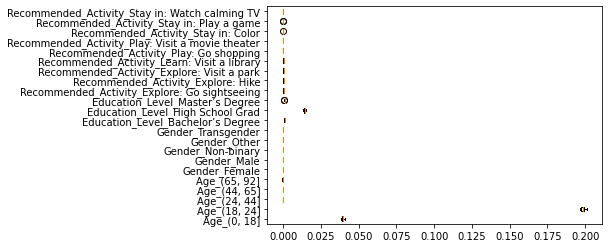

In [38]:
plt.boxplot(
    result.importances.T,
    vert=False,
    labels=orig_validate.feature_names,
)
# fig.tight_layout()
plt.show()

Question: Which interpretability mechanism did you choose? What are the key contributing factors?

**Your answer:**
We used permutation importance as it can be use show the sensitivity of the fitted model when facing randomness. From the graph we can see that age of 0-18 and 18-24 are important drivers. Similarly, we see that High school education influences the prediction values

## Step 5: Apply a bias mitigation strategy

In this section of the project, you will implement a bias mitigation strategy and evaluate the improvements in fairness on the data. Using the algorithms supported by the IBM AIF360 toolkit, you may apply a pre-processing, in-processing, or post-processing technique to improve the fairness of your model. Optionally, you may also consider combining multiple techniques.

**Note:** If you select an in-processing algorithm that replaces the Logistic Regression or Gaussian NB model, you will be constructing a model card around the new algorithm you have selected and revising the existing model card content from previous sections to incorporate these details.

In [39]:
#FILL IN - implement bias mitigation strategy

In [40]:
#FILL IN
#Obtain the new metric values after applying your bias mitigation strategy
from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier(max_depth=7, random_state=0)\
.fit(orig_train.features, orig_train.labels.ravel(), orig_train.instance_weights) 

thresh_arr = np.linspace(0.01, 0.5, 50)

val_metrics, rf_pred = test(dataset=orig_validate,
                   model=RF_model,
                   thresh_arr=thresh_arr)
describe_metrics(val_metrics, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.0100
Best balanced accuracy: 0.4169
Corresponding average odds difference value: -0.0834
Corresponding statistical parity difference value: -0.0982
Corresponding equal opportunity difference value: -0.0001
Corresponding Theil index value: 0.7537


**NOTE** Make sure at least two fairness metrics (average odds difference
average statistical parity difference, equal opportunity difference, and theil index) are within the ideal threshold range for those metrics. A slightly higher benefit for the privileged group may still be seen, which is ok.

Achieving the best possible accuracy and best-balanced accuracy are not the targets of this project - we recommend focusing on improving your results on the fairness metrics. It is recommended to have your balanced accuracy between 85%-100% but not required.

**IMPORTANT! If less than two fairness metrics are within the ideal range, re-work on your strategy.**

Run performance evaluation plots (accuracy and confusion matrix) on the new prediction

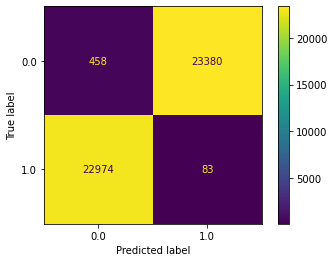

In [41]:
### FILL IN
accuracy_score(y_true=orig_validate.labels.ravel(), y_pred=rf_pred)
#Visualize the performance (confusion matrix) of the model
ConfusionMatrixDisplay.from_predictions(orig_validate.labels.ravel(), y_pred=rf_pred)
plt.savefig('confusion_matrix.png')

Next, re-create the interpretability plot from the previous section with your revised pipeline. 

In [42]:
### FILL IN
result = permutation_importance(RF_model, orig_validate.features,\
                           orig_validate.labels.ravel(),n_repeats=5,random_state=0)
print(result.importances_mean)
print(result.importances_std)

[ 5.58694957e-04  6.44844866e-02 -2.18786651e-03 -9.89444504e-04
 -4.98987099e-04 -2.13242350e-05  1.27945410e-05  6.82375520e-05
  2.13242350e-05  1.19415716e-04  2.78707751e-02  2.39684401e-03
  2.90649323e-02  2.13242350e-05  4.69133170e-05 -2.55890820e-05
 -7.67672460e-05 -2.85744749e-04 -7.67672460e-04  3.83836230e-05
  1.57799339e-04 -2.13242350e-05]
[8.24782156e-05 6.87553655e-04 3.69248079e-04 1.19567935e-04
 3.95505640e-05 4.67190581e-05 4.39092873e-05 3.13400969e-05
 4.04598912e-05 4.39092873e-05 2.05864478e-04 1.66602196e-04
 2.53390780e-04 4.04598912e-05 2.48681177e-05 1.59575963e-05
 5.15323424e-05 1.45630631e-04 1.25794914e-04 2.48681177e-05
 3.19151926e-05 1.34866304e-05]


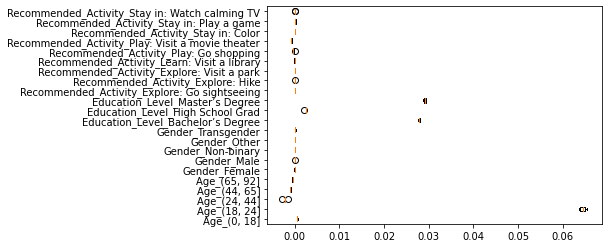

In [43]:
plt.boxplot(
    result.importances.T,
    vert=False,
    labels=orig_validate.feature_names,
)
# fig.tight_layout()
# plt.show()
plt.savefig('permutation_importance.png')

Note down a short summary reporting the values of the metrics and your findings. This will be the quantitative analysis section of the model card.
- Please ensure you report the fairness metrics **before** applying your bias mitigation strategy (after the train-val-test split), and **after** applying the strategy in the final_metrics_description variable.
- Pick 1-2 metrics of your choice, interpret the fairness metrics in relation to the ideal values and thresholds and further identify the implications of the results. 

In [44]:
final_metrics_description = """
--
--Before...
-- Threshold corresponding to Best balanced accuracy: 0.0100
-- Best balanced accuracy: 0.0125
-- Corresponding average odds difference value: -0.4531
-- Corresponding statistical parity difference value: -0.6036
-- Corresponding equal opportunity difference value: -0.0290
-- Corresponding Theil index value: 0.6846
--After...
-- Threshold corresponding to Best balanced accuracy: 0.0100
-- Best balanced accuracy: 0.4863
-- Corresponding average odds difference value: -0.0138
-- Corresponding statistical parity difference value: -0.0164
-- Corresponding equal opportunity difference value: 0.0000
-- Corresponding Theil index value: 0.7138
--
"""

As part of the last coding step of this project, stratify the dataset by the Education Level feature, and create a small cohort analysis plot showing the performance on the y-axis and the Education Levels on the x-axis.

In [45]:
##Fill in
acc={}
for col in ['Education_Level_Bachelor’s Degree',\
            'Education_Level_High School Grad', 'Education_Level_Master’s Degree']:
#     print(f"Education level - {col}\n Accuracy:")
    sel_col=orig_validate.features[:,orig_validate.feature_names.index(col)]
    acc[col]=accuracy_score(y_true=orig_validate.labels[sel_col==1].ravel(), y_pred=rf_pred[sel_col==1])


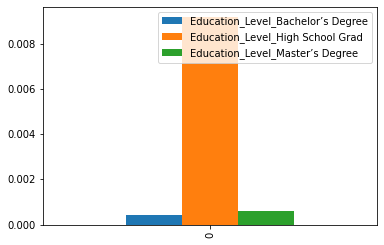

In [46]:
pd.DataFrame(acc,index=[0]).plot(kind='bar');
plt.savefig('cohort.png')

**Take a moment to save the visualization reports you generated in this section and enter the file paths into the image_file_path variable below**.

In [47]:
#FILL IN - save all visualization plots 
#from the "Apply a bias mitigation strategy" section
#plt.savefig('file_name.png')

#Replace the REPLACE_FILE_NAME placeholder with the image paths
#of the visualizations you have generated for the model card
image_file_path ="""
  <img src="confusion_matrix.png"><br/>
  <img src="permutation_importance.png"><br/>
  <img src="cohort.png"><br/>
"""

**Optional**: You may choose to create a cohort analysis plot showing the fairness metric values on the y-axis and the Education Levels on the x-axis.

In [48]:
#Optional save image for the fairness corhort analysis
#plt.savefig('images/optional_fairness_cohort_analysis') 

## Step 6: Articulate the ethical implications

Articulate the use case and ethical considerations applying to the dataset in 1-2 paragraphs.

**Hints:** 
 
- Think about the limitations of the dataset, potential biases that could be introduced into the use case, and the strengths and weaknesses of your ML model.
- Ethical Considerations:
 - Human-in-the-loop considerations: Can users control aspects of the model and inspect the features? If so, briefly describe how?
 - Describe the limitations and types of bias present in the data
 - Describe the failures of the ML model
 - It must include a section on any risk mitigation strategies you applied.
 - Describe Potential harms
 - It must include key contributing factors you found from your interpretability study, both before and after applying the bias mitigation strategy.

- Caveats and Recommendations
 - Potential lack of inclusiveness in the dataset
 - Predisposition of the model to false positives and/or negatives
 - It must also include 1-2 sentences on the further ethical AI analyses you would apply if given more time beyond this project.

In [49]:
#FILL IN
ethical_considerations="""
-- User can opt out of recommendations
-- User can opt out of selected features
-- Controlling limitations of biasness present in data by monitoring population stability index 
"""
caveats_and_recommendations="""
-- Certain users may opt out leading to sampled data being different from population
-- Data drift and feature distribution drift
-- Further ethical AI analyses I would apply beyond this project:
-- Zip Code to ensure certain area are always penalized
"""

- Business consequences
 - Potential positive impact of the IDOOU Budget Predicter AI
 - Reasons why users may lose trust in the application, and loss of revenue and brand reputation might occur to the organization

In [50]:
business_consequences="""

-- Positive Impact:
Users reach a critical mass where they can services differentiated experiences 
-- Negative Impact:
Users may distrust the AI solution leading to possible knee jerk reaction on future products
"""

## Document the solution in a model card

You're at the finish line! Run the last few blocks of code to generate a simple html file with your model card content and the visualizations you generated for the final version of your model.

Make sure to open the html file and check that it is reflective of your model card content before submitting.

Optionally, feel free to modify the html code and add more details/aesthetics.

In [51]:
html_code = f"""
<html>
  <head>
  </head>
  <body>
  <center><h1>Model Card - IDOOU AI Budget Predicter</h1></center>
  <h2>Model Details</h2>
  {model_details}
  <h2>Intended Use</h2>
  {intended_use}
  <h2>Factors</h2>
  {factors}
  <h2>Metrics</h2>
  {metrics}
  <h2> Training Data </h2>
  {training_data}
  <h2> Evaluation Data </h2>
  {eval_data}
  <h2>Quantitative Analysis</h2>
  {final_metrics_description}
  
  <br/><br/><b>Results of the AI model after applying the bias mitigation strategy</b><br/>
  
  <center>
  {image_file_path}
  </center>

  <h2>Ethical Considerations</h2>
  {ethical_considerations}
  <h2>Caveats and Recommendations</h2>
  {caveats_and_recommendations}
  <h2>Business Consequences</h2>
  {business_consequences}
  </body>
</html>"""
html_code = html_code.replace('--', '<br>--')

In [52]:
with open('model_card.html', 'w') as f:
    f.write(html_code)

Download and zip the .html report, the images you generated, and this Jupyter notebook, and you're ready for submission!